In [54]:
from __future__ import annotations

import warnings
warnings.filterwarnings("ignore", category=UserWarning)

from pathlib import Path
import numpy as np
import pandas as pd
import scipy.io
import mat73

from umap import UMAP


In [55]:
# Root experiment directory (Windows mapped drive)
expPath = Path(r"Z:\Homes\zutshi01\Recordings\Auditory_Task\mPFC")

# expPath = Path(r"Z:\Homes\zutshi01\Recordings\Auditory_Task")
# Your sessions (relative to expPath)
sessions = [
    r"IZ39\IZ39_220705_sess16",
    r"IZ39\IZ39_220707_sess17",
    r"IZ40\IZ40_220705_sess15",
    r"IZ40\IZ40_220707_sess16",
    r"IZ43\IZ43_220915_sess13",
    r"IZ43\IZ43_220920_sess15",
    r"IZ44\IZ44_220915_sess13",
    r"IZ44\IZ44_220920_sess15",
]

# sessions = [
#     r"IZ47\Final\IZ47_230707_sess24",
# ]
# Which conditions to run (suffix matches your filenames)
conditions = {
    "all": "",                 # no suffix
    "nostim_only": "_nostim_only",
    "stim_only": "_stim_only",
}

# conditions = {
#     "all": "",
# }

# UMAP parameters (set random_state for reproducibility)
umap_params = dict(
    n_neighbors=20,
    n_components=6,
    metric="cosine",
    min_dist=0.1,
    init="spectral",
    n_jobs=-1,
    random_state=0,  # reproducible
)


In [56]:
def load_mat_variable(mat_path: Path, varname: str):
    """
    Load `varname` from a .mat file.
    Tries scipy.io.loadmat first (MATLAB v7 and earlier),
    falls back to mat73 for v7.3 files.
    """
    try:
        d = scipy.io.loadmat(mat_path, squeeze_me=True, struct_as_record=False)
        if varname not in d:
            raise KeyError(f"Variable '{varname}' not found in {mat_path.name}. Keys: {list(d.keys())[:20]}")
        return d[varname]
    except NotImplementedError:
        d = mat73.loadmat(str(mat_path))
        if varname not in d:
            raise KeyError(f"Variable '{varname}' not found in {mat_path.name}. Keys: {list(d.keys())[:20]}")
        return d[varname]


In [57]:
def pick_data_file(manifold_dir: Path, condition: str) -> Path:
    """
    condition ∈ {"all", "nostim_only", "stim_only"}
    """
    files = list(manifold_dir.glob("*.data_behavior_*.mat"))
    if not files:
        raise FileNotFoundError(f"No data_behavior files in {manifold_dir}")

    if condition == "all":
        candidates = [f for f in files if not f.stem.endswith(("_nostim_only", "_stim_only"))]
    else:
        token = f"_{condition}"
        candidates = [f for f in files if f.stem.endswith(token)]

    if len(candidates) != 1:
        raise RuntimeError(
            f"{condition}: expected 1 file, found {len(candidates)}\n" +
            "\n".join(f.name for f in candidates)
        )

    return candidates[0]



In [58]:
def run_umap_and_save(data_mat: Path, out_dir: Path, condition_name: str, params: dict):
    """
    Loads `data` from the .mat file, runs UMAP, and saves a CSV.
    Output naming avoids double condition suffixes.
    """
    # Load data
    X = load_mat_variable(data_mat, "data")
    X = np.asarray(X)

    if X.ndim != 2:
        raise ValueError(f"'data' in {data_mat.name} is not 2D. Got shape: {X.shape}")

    # Run UMAP
    model = UMAP(**params)
    emb = model.fit_transform(X)

    # Build clean output filename
    stem = data_mat.stem
    if condition_name == "all":
        out_name = f"Umap_{stem}_all.csv"
    elif stem.endswith(f"_{condition_name}"):
        out_name = f"Umap_{stem}.csv"
    else:
        out_name = f"Umap_{stem}_{condition_name}.csv"

    out_path = out_dir / out_name

    # Save
    pd.DataFrame(emb).to_csv(out_path, header=False, index=False)

    return out_path, emb



In [59]:
conditions = ["all", "nostim_only", "stim_only"]
# conditions = ["all"]

results = []

for sess in sessions:
    manifold_dir = expPath / sess / "manifold"

    if not manifold_dir.exists():
        print(f"[SKIP] No manifold folder: {manifold_dir}")
        continue

    print(f"\n=== Session: {sess} ===")

    for cond in conditions:
        try:
            data_mat = pick_data_file(manifold_dir, cond)

            out_csv, emb = run_umap_and_save(
                data_mat=data_mat,
                out_dir=manifold_dir,
                condition_name=cond,
                params=umap_params,
            )

            print(f"[OK] {cond:10s} -> {out_csv.name} (emb shape {emb.shape})")
            results.append((sess, cond, str(data_mat), str(out_csv), emb.shape))

        except Exception as e:
            print(f"[FAIL] {cond:10s} -> {e}")



=== Session: IZ39\IZ39_220705_sess16 ===
[OK] all        -> Umap_IZ39_220705_sess16.data_behavior_speed_1_smooth_5_bin_0.1_all.csv (emb shape (20409, 6))
[OK] nostim_only -> Umap_IZ39_220705_sess16.data_behavior_speed_1_smooth_5_bin_0.1_nostim_only.csv (emb shape (13856, 6))
[OK] stim_only  -> Umap_IZ39_220705_sess16.data_behavior_speed_1_smooth_5_bin_0.1_stim_only.csv (emb shape (6553, 6))

=== Session: IZ39\IZ39_220707_sess17 ===
[OK] all        -> Umap_IZ39_220707_sess17.data_behavior_speed_1_smooth_5_bin_0.1_all.csv (emb shape (18674, 6))
[OK] nostim_only -> Umap_IZ39_220707_sess17.data_behavior_speed_1_smooth_5_bin_0.1_nostim_only.csv (emb shape (12207, 6))
[OK] stim_only  -> Umap_IZ39_220707_sess17.data_behavior_speed_1_smooth_5_bin_0.1_stim_only.csv (emb shape (6467, 6))

=== Session: IZ40\IZ40_220705_sess15 ===
[OK] all        -> Umap_IZ40_220705_sess15.data_behavior_speed_1_smooth_5_bin_0.1_all.csv (emb shape (21503, 6))
[OK] nostim_only -> Umap_IZ40_220705_sess15.data_behavi

In [60]:
summary = pd.DataFrame(
    results,
    columns=["session", "condition", "input_mat", "output_csv", "embedding_shape"]
)
summary


,session,condition,input_mat,output_csv,embedding_shape
0,IZ39\IZ39_220705_sess16,all,Z:\Homes\zutshi01\Recordings\Auditory_Task\mPF...,Z:\Homes\zutshi01\Recordings\Auditory_Task\mPF...,"(20409, 6)"
1,IZ39\IZ39_220705_sess16,nostim_only,Z:\Homes\zutshi01\Recordings\Auditory_Task\mPF...,Z:\Homes\zutshi01\Recordings\Auditory_Task\mPF...,"(13856, 6)"
2,IZ39\IZ39_220705_sess16,stim_only,Z:\Homes\zutshi01\Recordings\Auditory_Task\mPF...,Z:\Homes\zutshi01\Recordings\Auditory_Task\mPF...,"(6553, 6)"
3,IZ39\IZ39_220707_sess17,all,Z:\Homes\zutshi01\Recordings\Auditory_Task\mPF...,Z:\Homes\zutshi01\Recordings\Auditory_Task\mPF...,"(18674, 6)"
4,IZ39\IZ39_220707_sess17,nostim_only,Z:\Homes\zutshi01\Recordings\Auditory_Task\mPF...,Z:\Homes\zutshi01\Recordings\Auditory_Task\mPF...,"(12207, 6)"
5,IZ39\IZ39_220707_sess17,stim_only,Z:\Homes\zutshi01\Recordings\Auditory_Task\mPF...,Z:\Homes\zutshi01\Recordings\Auditory_Task\mPF...,"(6467, 6)"
6,IZ40\IZ40_220705_sess15,all,Z:\Homes\zutshi01\Recordings\Auditory_Task\mPF...,Z:\Homes\zutshi01\Recordings\Auditory_Task\mPF...,"(21503, 6)"
7,IZ40\IZ40_220705_sess15,nostim_only,Z:\Homes\zutshi01\Recordings\Auditory_Task\mPF...,Z:\Homes\zutshi01\Recordings\Auditory_Task\mPF...,"(13092, 6)"
8,IZ40\IZ40_220705_sess15,stim_only,Z:\Homes\zutshi01\Recordings\Auditory_Task\mPF...,Z:\Homes\zutshi01\Recordings\Auditory_Task\mPF...,"(8411, 6)"
9,IZ40\IZ40_220707_sess16,all,Z:\Homes\zutshi01\Recordings\Auditory_Task\mPF...,Z:\Homes\zutshi01\Recordings\Auditory_Task\mPF...,"(17716, 6)"


In [61]:
import matplotlib.pyplot as plt

def plot_session_three_conditions(summary, session, dims=(0, 1, 2), s=2):
    conds = ["all", "nostim_only", "stim_only"]

    fig = plt.figure(figsize=(16, 5), dpi=150)

    for i, cond in enumerate(conds, start=1):
        row = summary[(summary.session == session) & (summary.condition == cond)]
        if row.empty:
            print(f"[SKIP] {cond} missing for {session}")
            continue

        emb = pd.read_csv(row.iloc[0].output_csv, header=None).to_numpy()

        ax = fig.add_subplot(1, 3, i, projection="3d")
        ax.scatter(emb[:, dims[0]], emb[:, dims[1]], emb[:, dims[2]], s=s)
        ax.set_title(f"{session}\n{cond}")
        ax.set_axis_off()

    plt.tight_layout()
    plt.show()


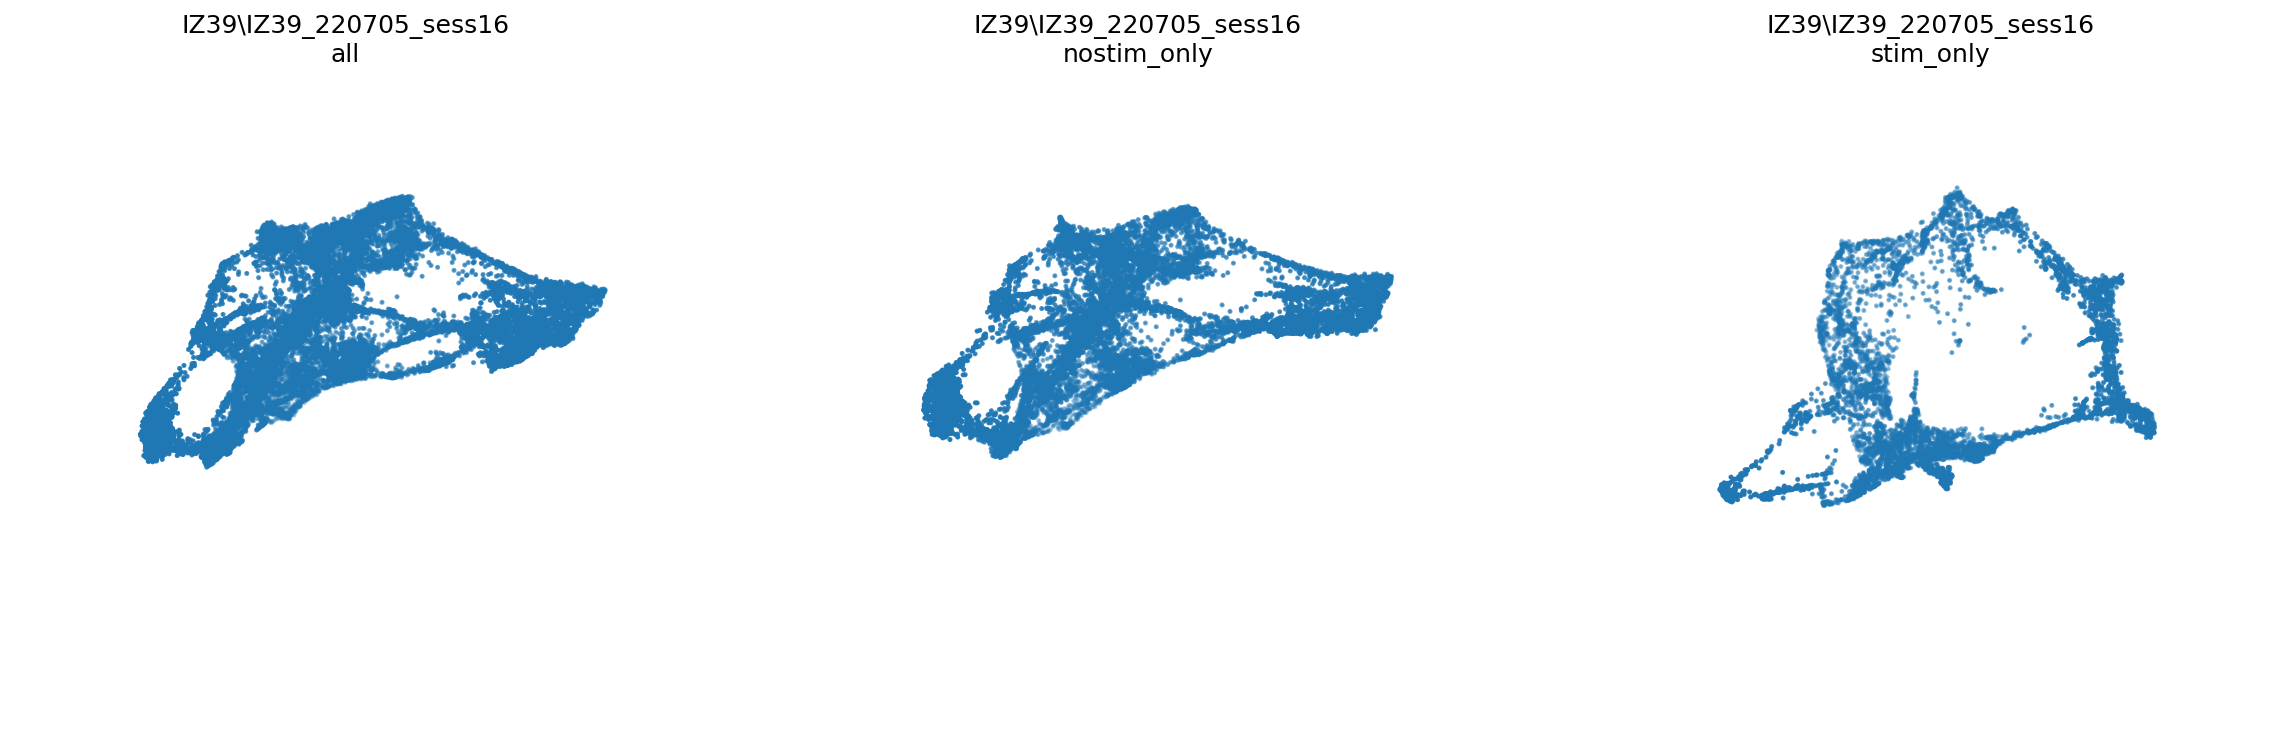

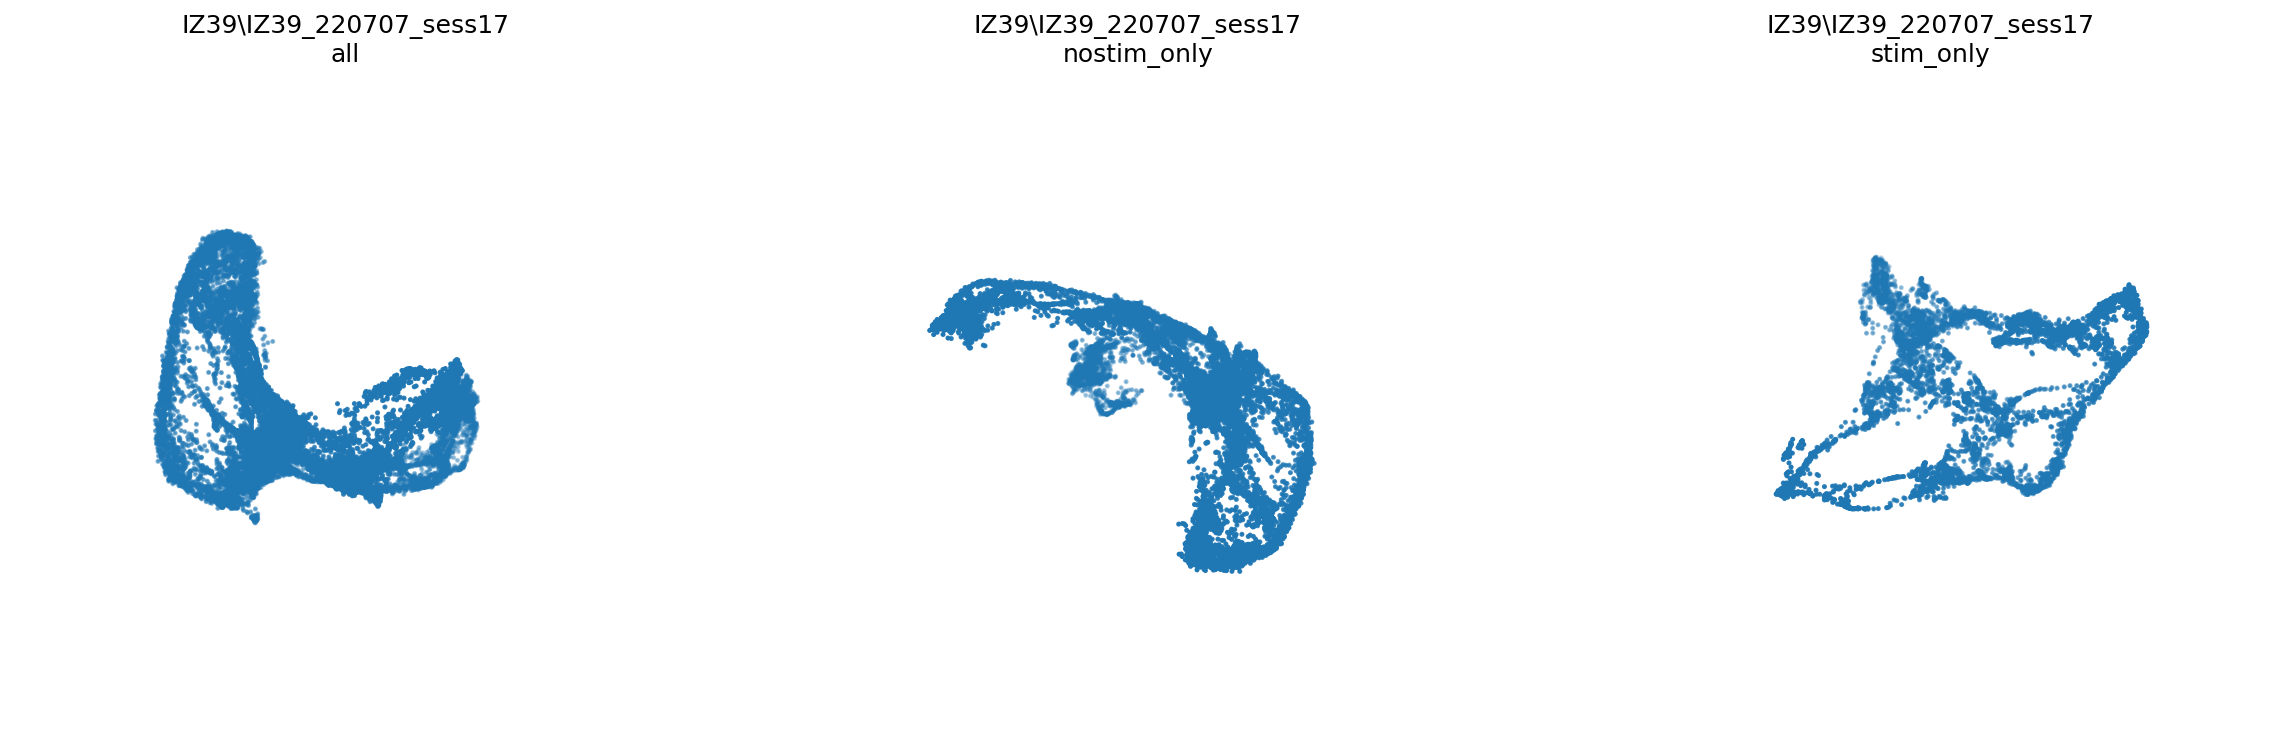

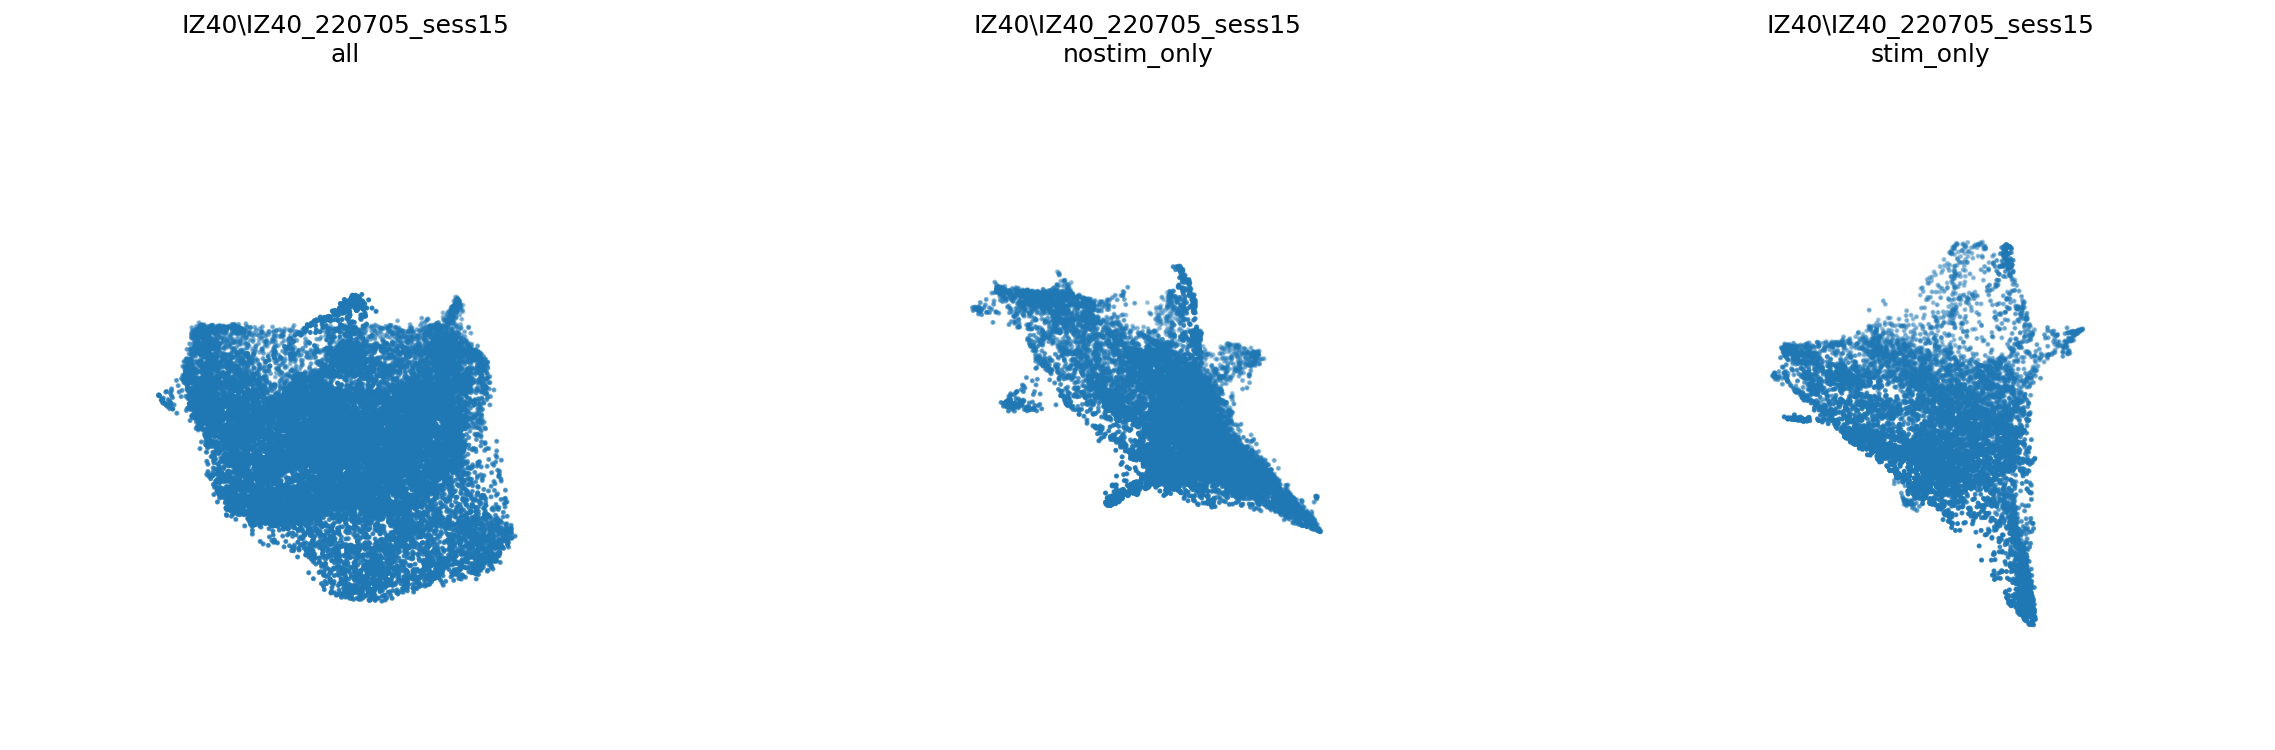

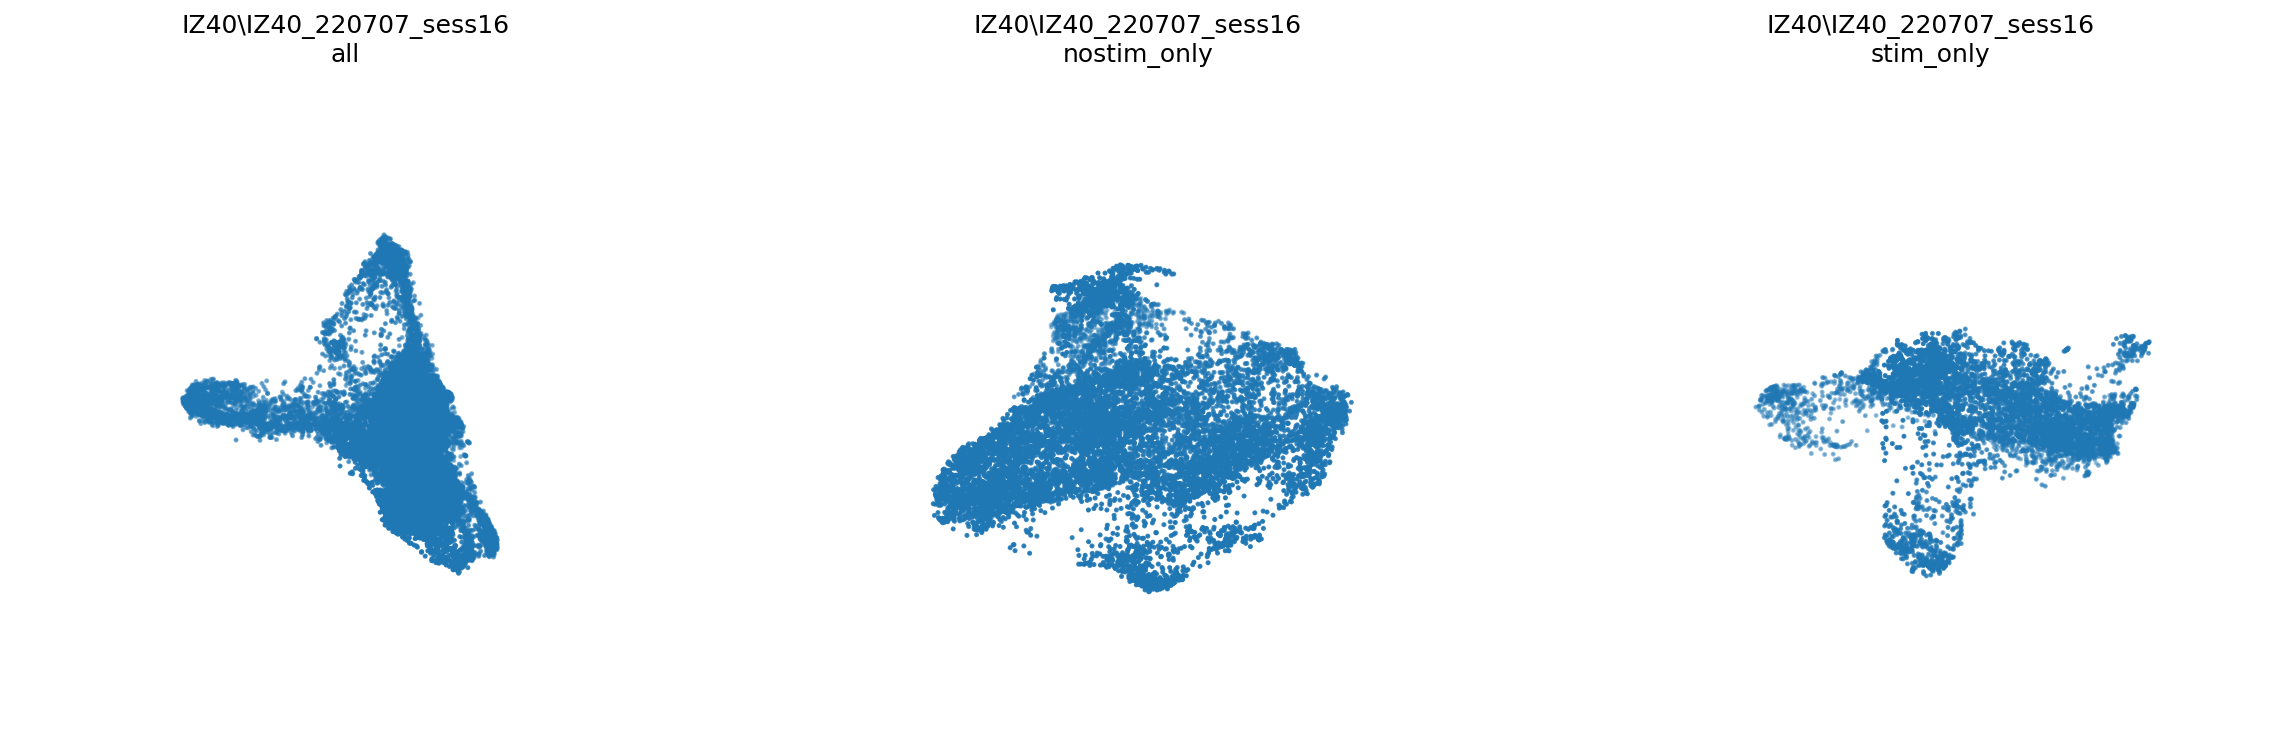

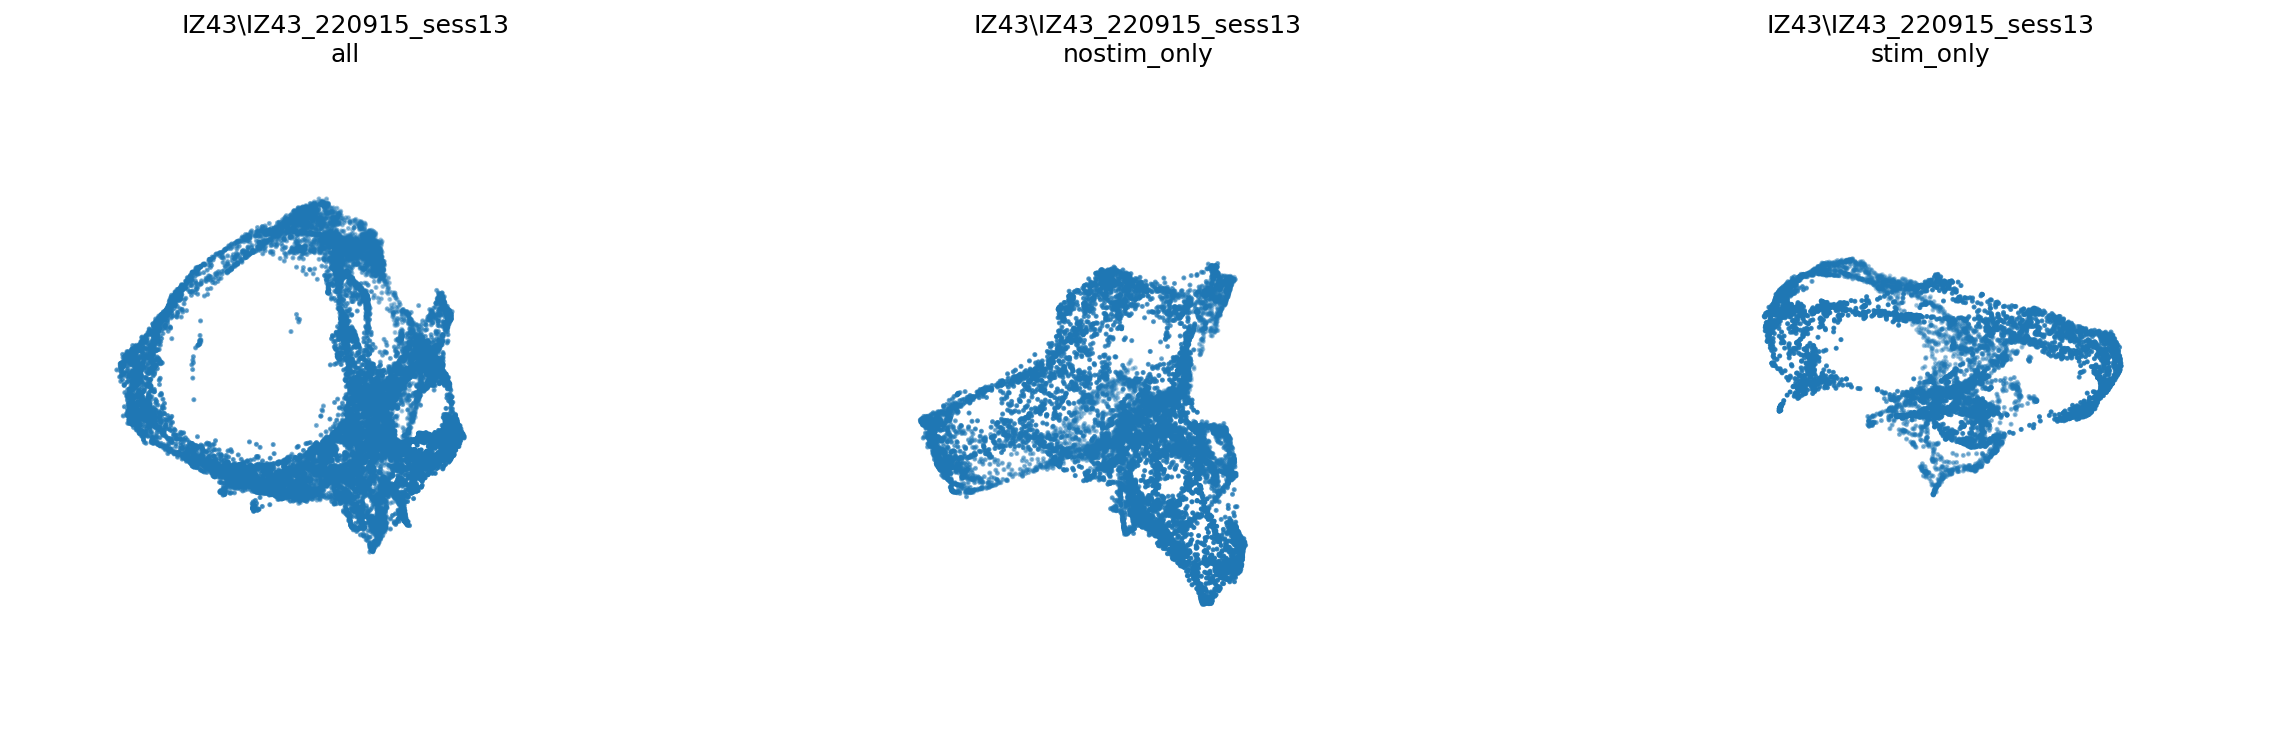

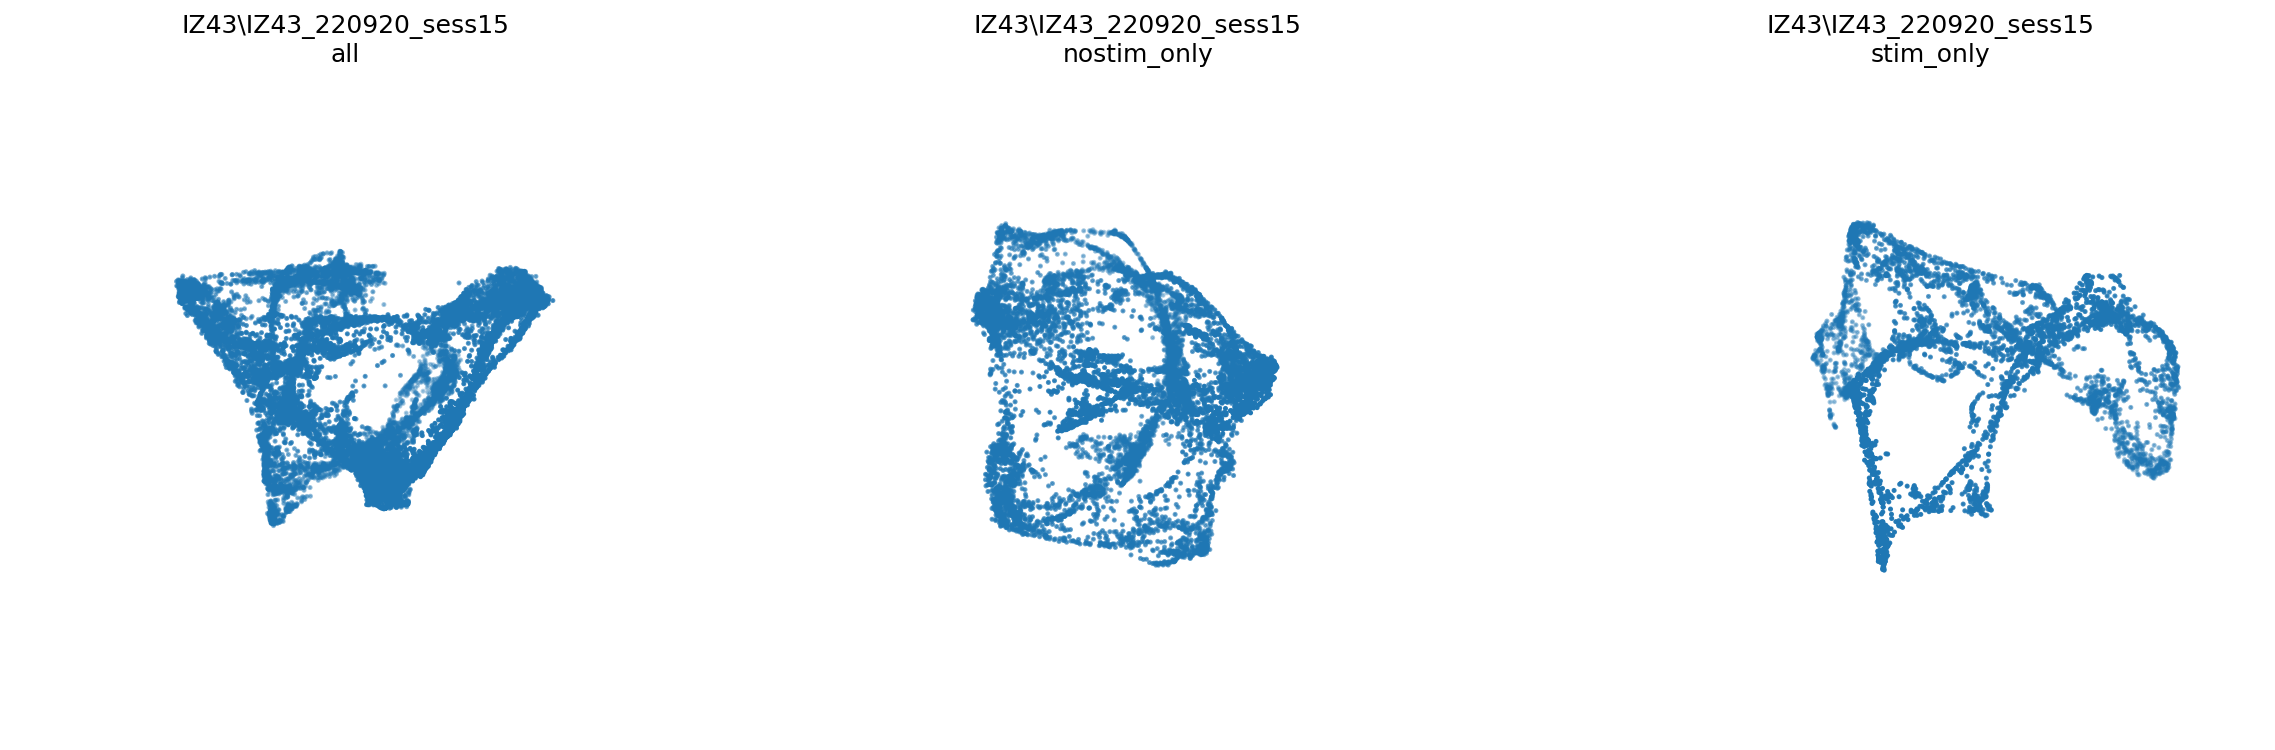

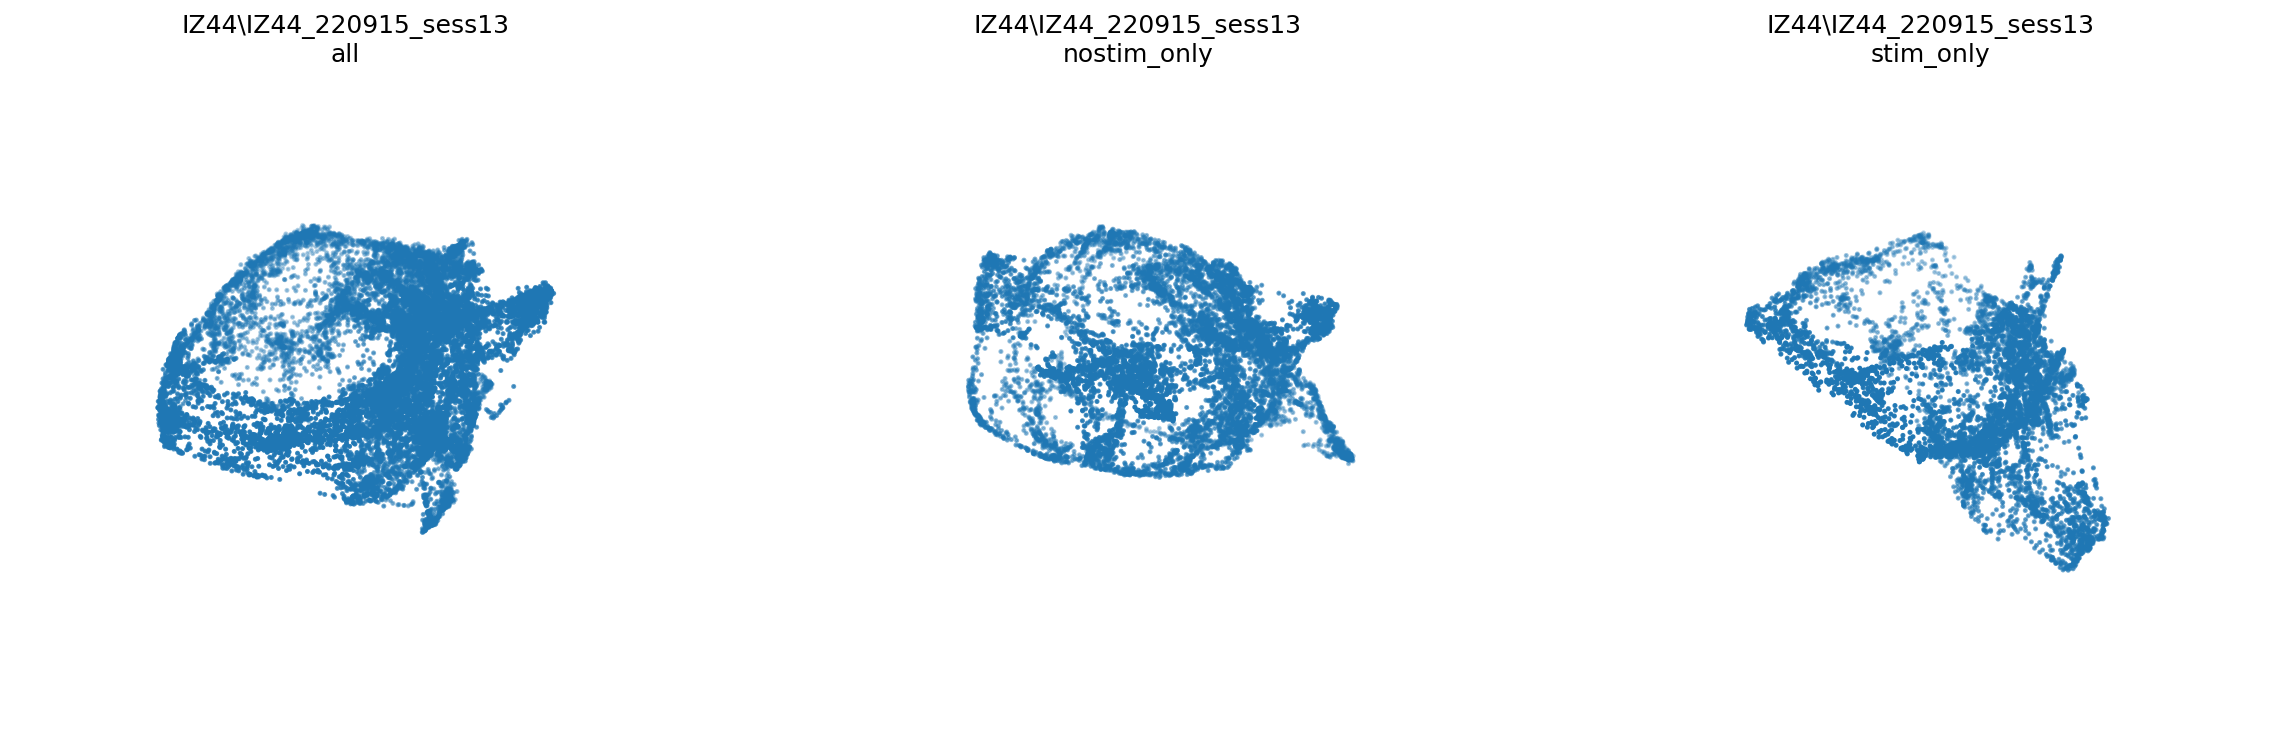

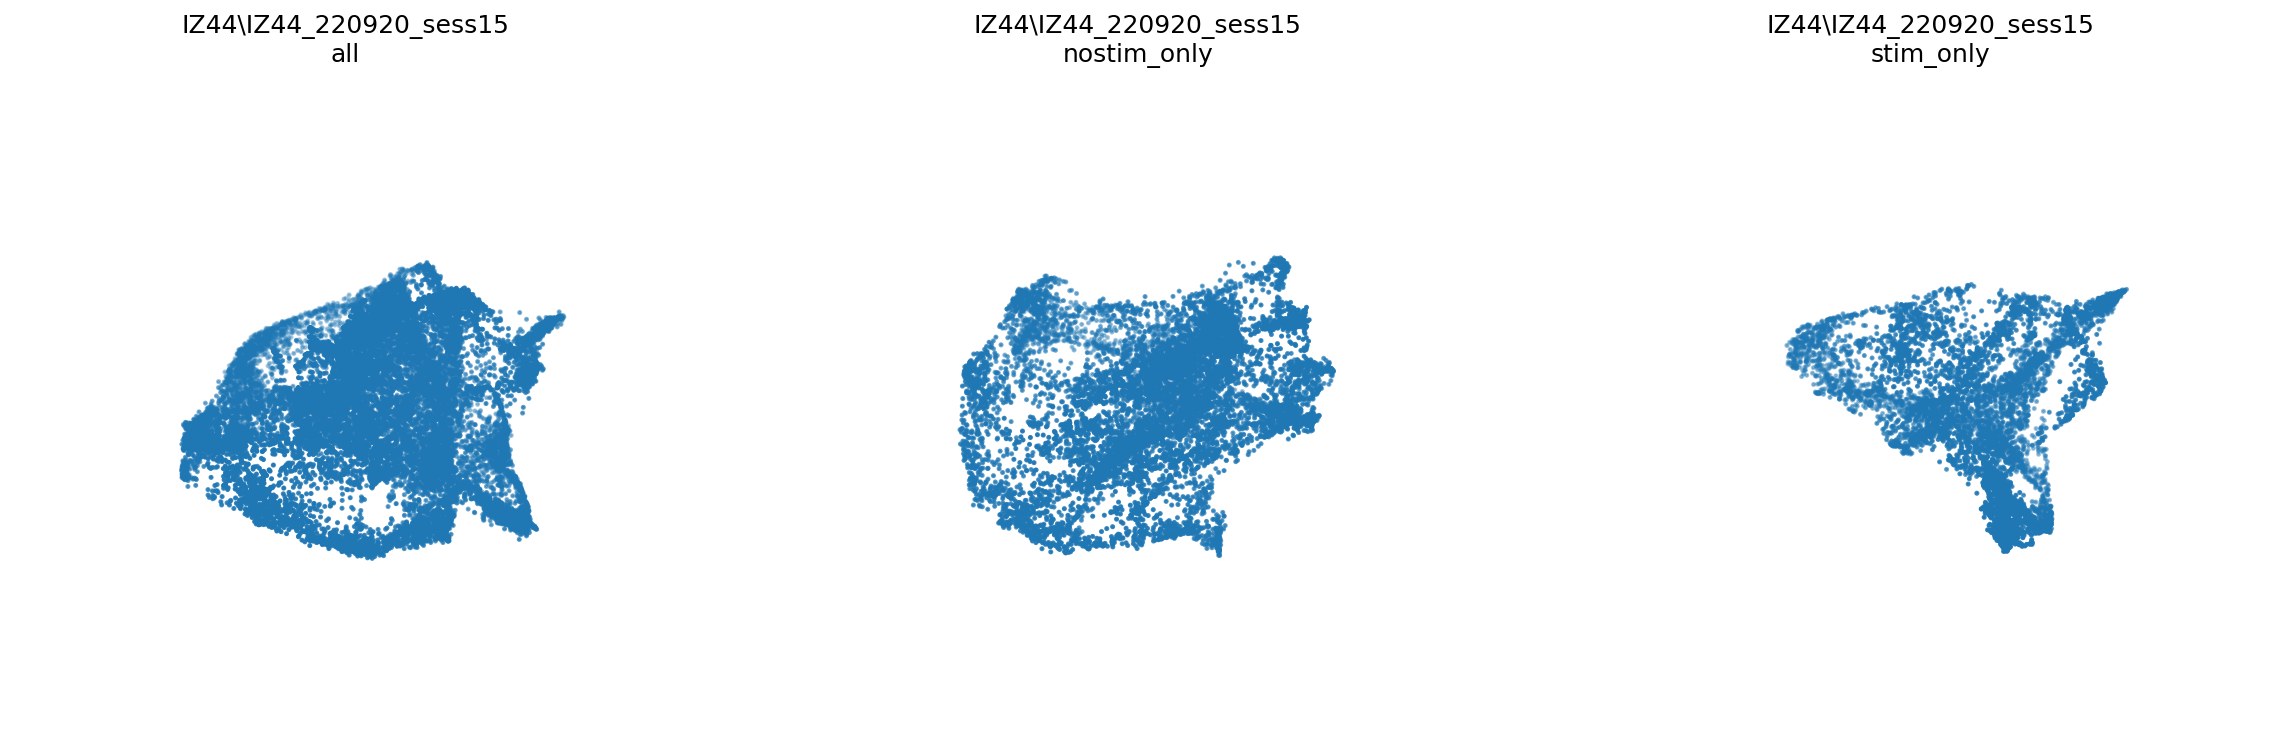

In [62]:
for sess in summary.session.unique():
    plot_session_three_conditions(summary, sess)


In [44]:
test_session = r"IZ43\IZ43_220920_sess15"
test_condition = "all"   # use "all" first

In [45]:
# Find the row in summary
row = summary[
    (summary.session == test_session) &
    (summary.condition == test_condition)
].iloc[0]

# Load the original data used for UMAP
X = load_mat_variable(Path(row.input_mat), "data")
X = np.asarray(X)

X.shape


(15622, 253)

In [48]:
from umap import UMAP
from sklearn.manifold import trustworthiness
from sklearn.neighbors import NearestNeighbors

def neighbor_overlap(emb_list, k=15):
    knn_sets = []
    for emb in emb_list:
        idx = NearestNeighbors(n_neighbors=k+1).fit(emb).kneighbors(return_distance=False)[:, 1:]
        knn_sets.append([set(row) for row in idx])

    overlaps = []
    for i in range(len(knn_sets)):
        for j in range(i+1, len(knn_sets)):
            per_point = []
            for a, b in zip(knn_sets[i], knn_sets[j]):
                per_point.append(len(a & b) / k)
            overlaps.append(np.mean(per_point))
    return float(np.mean(overlaps)), overlaps


def umap_stability_report(X, seeds, umap_kwargs, k=15):
    embs = []
    tws = []
    for s in seeds:
        emb = UMAP(**umap_kwargs, random_state=s).fit_transform(X)
        embs.append(emb[:, :2])  # use first 3 dims for neighborhood structure
        tw = trustworthiness(
            X,
            emb[:, :2],
            n_neighbors=k,
            metric=umap_kwargs.get("metric", "euclidean")
        )
        tws.append((s, tw))

    mean_overlap, all_pair_overlaps = neighbor_overlap(embs, k=k)
    return tws, mean_overlap, all_pair_overlaps


In [49]:
seeds = [0, 1, 2, 5, 10, 20, 42, 99]

umap_kwargs = dict(
    n_neighbors=20,
    n_components=6,
    metric="cosine",
    min_dist=0.1,
    init="spectral",
    n_jobs=-1,
)

tws, mean_overlap, pair_overlaps = umap_stability_report(
    X,
    seeds=seeds,
    umap_kwargs=umap_kwargs,
    k=15
)

tws, mean_overlap


([(0, 0.8330902926314392),
  (1, 0.8335825362970833),
  (2, 0.832153859452505),
  (5, 0.8335628187005905),
  (10, 0.8339992340520533),
  (20, 0.8316225679751309),
  (42, 0.8298548231019529),
  (99, 0.8313180999867517)],
 0.21222482335656068)